In [1]:
import covasim as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import json
from scipy.optimize import minimize
import sys 
sys.path.append('./models/')
from useful_functions import differenciate


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


The simulation will take place between start_day and end_day. covasim can not support simulations longer thanb 150 days

In [2]:
start_day = '2020-03-02'
end_day   = '2021-01-01'
date_range = pd.date_range(start=start_day, end=end_day, freq='D')
all_days = cv.date_range(start_day, end_day)
beta_initial=0.015

We use Gerlee et al. to have a moving beta according to the data from the traffic. 

In [3]:
# defining a moving beta accoding to the article predicting regional covid 19 hospital admissions in Sweden using mobility data

mobility='''0
-0,0436877025562212
-0,142183890633573
-0,414264196497882
-0,490226517606742
-0,520691444229291
-0,601104998394856
-0,565468289968282
-0,500887028474234
-0,533539503417897
-0,489363271950639
-0,479732407975015
-0,525650201055078
-0,4254
-0,4325
-0,394
-0,53
-0,47
-0,5
-0,53
-0,56
-0,55
-0,53
-0,5
-0,47
-0,39
-0,35
-0,34
-0,34
-0,33
-0,33
-0,32
-0,31
-0,32
-0,31
-0,42
-0,41
-0,43
-0,45
-0,44
-0,44
-0,51
-0,51
-0,66
-0,77
'''.replace(',','.').split('\n')


floatmobility = [float(i) for i in mobility if i != '']
betas = [ 4.11 + 6.68 * mob for mob in floatmobility]
betas_by_week=np.array([betas[i//7] for i in range(len(all_days))])
# coeff_betas=[betas_by_week[i+1]/betas_by_week[i] for i in range(len(betas_by_week)-1)]
coeff_betas=[betas_by_week[i]/beta_initial for i in range(len(betas_by_week))]


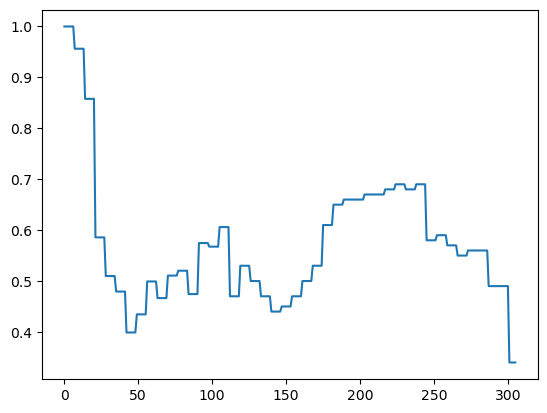

In [4]:
coef_mobility=[1+floatmobility[i] for i in range(len(floatmobility))]
coef_mobility_by_week=np.array([coef_mobility[i//7] for i in range(len(all_days))])
plt.plot(coef_mobility_by_week)


In [5]:
# storing the mobility in a csv file
store_mobility=False
if store_mobility:
    mobility_by_week=np.array([floatmobility[i//7] for i in range(len(all_days))])
    mobility_df=pd.DataFrame({'mobility': mobility_by_week})
    mobility_df.to_csv('mobility_bis.csv')


In [6]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)

The values of beta seem very high compared to the previsous values found in litrerature. 


Creating parameters that fit the Swedish population

In [7]:
# parameters_sweden=dict(pop_size=100000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
#                                              # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

#                             start_day = start_day,
#                             end_day   = end_day,
#                             pop_type = 'hybrid',
#                             beta=3,  
#                             location = 'Sweden',
#                             pop_infected = 100, 
                            
#                             )

parameters_sweden_bis=dict(pop_size=1000000,  #  10 368 969 is population in Sweden in 2019 according to https://www.worldometers.info/ 
                                             # 1608037 is the population in Stockholm in 2019 according to https://worldpopulationreview.com/

                            start_day = start_day,
                            end_day   = end_day,
                            pop_type = 'hybrid',
                            beta=0.015,  
                            location = 'Sweden',
                            pop_infected = 100, 
                            
                            )



In [ ]:
all_simuls=[]
for i in range(14): 
    coefs = [ 1 for _ in range(14)]
    coefs[i]=2
    params_custom = dict(
    pop_size=50000,
    start_day='2020-03-01',
    end_day='2021-03-01',
    pop_type='hybrid',
    beta=0.015,
    location='Sweden',
    pop_infected=10,
    dur={
        'exp2inf': {'dist':'lognormal_int', 'par1':4.5*coefs[0], 'par2':1.5}, # par 1 = mean of the log normal distrib, par 2 = std of the log normal distrib. par1 represents the expected value of the number of days between exposure and infection
        'inf2sym': {'dist':'lognormal_int', 'par1':1.1*coefs[1], 'par2':0.9},
        'sym2sev': {'dist':'lognormal_int', 'par1':6.6*coefs[2], 'par2':4.9},
        'sev2crit': {'dist':'lognormal_int', 'par1':1.5*coefs[3], 'par2':2.0},
        'asym2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[4], 'par2':2.0},
        'mild2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[5], 'par2':2.0},
        'sev2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[6], 'par2':6.3},
        'crit2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[7], 'par2':6.3},
        'crit2die': {'dist':'lognormal_int', 'par1':10.7*coefs[8], 'par2':4.8},
    }, 
    rel_symp_prob= 1.0*coefs[9],
    rel_severe_prob=1.0*coefs[10],
    rel_crit_prob=1.0*coefs[11],
    rel_death_prob=1.0*coefs[12]
    )
    
    # Define mobility coefficients and interventions
    all_days = cv.date_range(params_custom['start_day'], params_custom['end_day'])
    coef_mobility_custom = [1 for _ in range(len(all_days))]
    interventions_custom = cv.change_beta(days=all_days, changes=coef_mobility_custom, do_plot=False)

    # Create and run the simulation
    mysimul = cv.Sim(params_custom, interventions=interventions_custom)
    mysimul.run()
    all_simuls.append(np.array(mysimul.results['n_severe']))
    # Plot results
    plt.plot(mysimul.results['n_severe'])
    plt.xlabel('Day')
    plt.ylabel('Number of severe cases')
    plt.title('Number of severe cases over time with '+ str(i)+' -th parameter changed')
    plt.show()



In [9]:
def diff_between_2_arrays(array1, array2): 
    derive1=np.array(differenciate(array1))
    derive2=np.array(differenciate(array2))
    derivee1=np.array(differenciate(derive1))
    derivee2=np.array(differenciate(derive2))
    max1=max(array1)
    max2=max(array2)
    maxder1=max(derive1)
    maxder2=max(derive2)
    maxderder1=max(derivee1)
    maxderder2=max(derivee2)
    ar1_normalized=array1/np.sum(abs(array1))
    ar2_normalized=array2/np.sum(abs(array2))
    der1_normalized=derive1/np.sum(abs(derive1))
    der2_normalized=derive2/np.sum(abs(derive2))
    derder1_normalized=derivee1/np.sum(abs(derivee1))
    derder2_normalized=derivee2/np.sum(abs(derivee2))
    res=[]
    if max1>max2: 
        res.append(max1/max2 -1)
    else : 
        res.append(max2/max1-1)
    if maxder1>maxder2:
        res.append(maxder1/maxder2-1)
    else :
        res.append(maxder2/maxder1-1)
    if maxderder1>maxderder2:
        res.append(maxderder1/maxderder2-1)
    else :
        res.append(maxderder2/maxderder1-1)
    res.append(np.sum([abs(ar1_normalized[i]-ar2_normalized[i]) for i in range(len(ar1_normalized))]))
    res.append(np.sum([abs(der1_normalized[i]-der2_normalized[i]) for i in range(len(der1_normalized))]))
    res.append(np.sum([abs(derder1_normalized[i]-derder2_normalized[i]) for i in range(len(derder1_normalized))]))
    res=np.array(res)
    return np.sum(res**2)
            



In [10]:
def dissemblance(pandemic1, pandemic2, pandemic3, pandemic4): 
    return diff_between_2_arrays(pandemic1, pandemic2)+diff_between_2_arrays(pandemic1, pandemic3)+diff_between_2_arrays(pandemic1, pandemic4)+diff_between_2_arrays(pandemic2, pandemic3)+diff_between_2_arrays(pandemic2, pandemic4)+diff_between_2_arrays(pandemic3, pandemic4)

In [11]:
diff_max=0
imax=0
jmax=0
kmax=0
lmax=0

for i in range( 14):
    print(i)
    for j in range(i+1, 14): 
        for k in range(j+1, 14): 
            for l in range(k+1, 14): 
                diff=dissemblance(all_simuls[i], all_simuls[j], all_simuls[k], all_simuls[l])
                if diff>diff_max: 
                    diff_max=diff
                    print(i, j, k, l, diff_max)
                    imax=i
                    jmax=j
                    kmax=k
                    lmax=l


0
0 1 2 3 38.5875388583436
0 1 2 4 40.65617701626744
0 1 2 5 42.42389542207567
0 1 2 10 46.089466683018706
0 1 4 10 47.61054845068788
0 1 5 10 48.6196561813687
0 1 10 12 48.72926301480956
0 2 5 10 49.18689315475542
0 4 10 12 49.77237246240248
0 5 10 12 50.53762278266023
1
2
3
4
5
6
7
8
9
10
11
12
13


Text(0.5, 1.0, '4 most different simulations for dissemblance2')

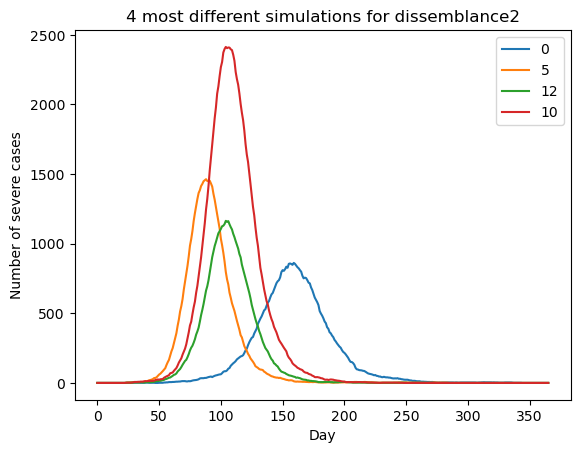

In [28]:
plt.plot(all_simuls[0], label='0')
plt.plot(all_simuls[5], label='5')
plt.plot(all_simuls[12], label='12')
plt.plot(all_simuls[10], label='10')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number of severe cases')
plt.title('4 most different simulations for dissemblance2')

Text(0.5, 1.0, '4 most different simulations for dissemblance1')

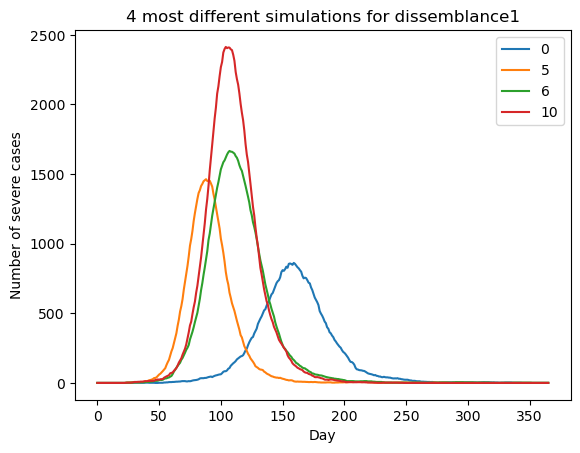

In [27]:
plt.plot(all_simuls[0], label='0')
plt.plot(all_simuls[5], label='5')
plt.plot(all_simuls[6], label='6')
plt.plot(all_simuls[10], label='10')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number of severe cases')
plt.title('4 most different simulations for dissemblance1')

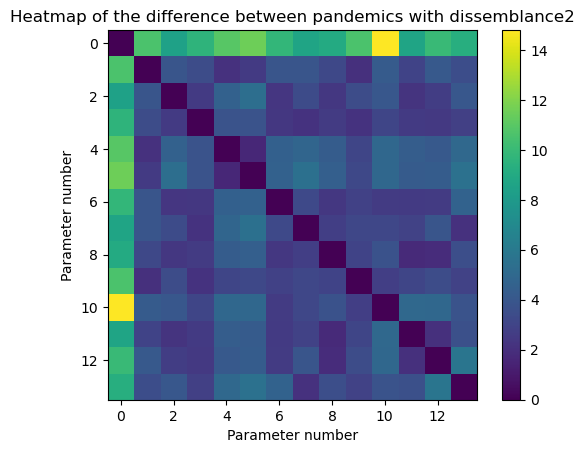

In [14]:
# heatmap of the difference between arrays : 
diffs=[]
for i in range(14): 
    diffs.append([diff_between_2_arrays(all_simuls[i], all_simuls[j]) for j in range(14)])
plt.imshow(diffs)
plt.colorbar()
plt.title('Heatmap of the difference between pandemics with dissemblance2')
plt.xlabel('Parameter number')
plt.ylabel('Parameter number')
# add the namf the loss function o,n the scale : 
plt.show()




MONTE CARLO BEGINS 

In [15]:
import numpy as np

In [16]:
def all_combinaison(params): 
    p1=params[0]
    p2=params[1]
    p3=params[2]
    p4=params[3]
    # returns all the 16 sets that I can make with {p1, p2, p3, p4}: 
    return [[], [p1], [p2], [p3], [p4], [p1, p2], [p1, p3], [p1, p4], [p2, p3], [p2, p4], [p3, p4], [p1, p2, p3], [p1, p2, p4], [p1, p3, p4], [p2, p3, p4], [p1, p2, p3, p4]]

In [17]:
def create_params(combinaison): 
    coefs = [ 1 for _ in range(14)]
    for p in combinaison: 
        coefs[p]=2
    

    params_custom = dict(
    pop_size=10000,
    start_day='2020-03-01',
    end_day='2021-03-01',
    pop_type='hybrid',
    beta=0.015,
    location='Sweden',
    pop_infected=10,
    dur={
        'exp2inf': {'dist':'lognormal_int', 'par1':4.5*coefs[0], 'par2':1.5}, # par 1 = mean of the log normal distrib, par 2 = std of the log normal distrib. par1 represents the expected value of the number of days between exposure and infection
        'inf2sym': {'dist':'lognormal_int', 'par1':1.1*coefs[1], 'par2':0.9},
        'sym2sev': {'dist':'lognormal_int', 'par1':6.6*coefs[2], 'par2':4.9},
        'sev2crit': {'dist':'lognormal_int', 'par1':1.5*coefs[3], 'par2':2.0},
        'asym2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[4], 'par2':2.0},
        'mild2rec': {'dist':'lognormal_int', 'par1':8.0*coefs[5], 'par2':2.0},
        'sev2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[6], 'par2':6.3},
        'crit2rec': {'dist':'lognormal_int', 'par1':18.1*coefs[7], 'par2':6.3},
        'crit2die': {'dist':'lognormal_int', 'par1':10.7*coefs[8], 'par2':4.8},
    }, 
    rel_symp_prob= 1.0*coefs[9],
    rel_severe_prob=1.0*coefs[10],
    rel_crit_prob=1.0*coefs[11],
    rel_death_prob=1.0*coefs[12]
    )
    return params_custom

In [18]:
def create_pandemic(dico):
    mysimul = cv.Sim(dico)
    mysimul.run()
    return np.array(mysimul.results['n_severe'])

In [19]:
def loss(params): # params are the numero of the parameters to change 
    combinaisons=all_combinaison(params)
    pandemics=[create_pandemic(create_params(combinaisons[i])) for i in range(16)]
    loss=0
    for i in range(16): 
        for j in range(i+1, 16): 
            loss+=diff_between_2_arrays(pandemics[i], pandemics[j])
    return loss

In [20]:
params_init=[0, 5, 6, 10]
loss_init=loss(params_init) 
params=params_init
dicocount=dict()
dicocount[str(params_init)]=1
dicoloss=dict()
dicoloss[str(params_init)]=loss_init
# ATTENTION PENSER A ORDONNER LES PARAMETRES CAR SINON ON AURA DES DOUBLONS
# attention il fait trouver un moyenr que les probas de transitions ne soient pas toutes égales à 0.9999999

Initializing sim with 10000 people for 365 days
Loading location-specific data for "Sweden"
  Running 2020-03-01 ( 0/365) (0.98 s)  ———————————————————— 0%
  Running 2020-03-11 (10/365) (1.30 s)  ———————————————————— 3%
  Running 2020-03-21 (20/365) (1.54 s)  •——————————————————— 6%
  Running 2020-03-31 (30/365) (1.80 s)  •——————————————————— 8%
  Running 2020-04-10 (40/365) (2.11 s)  ••—————————————————— 11%
  Running 2020-04-20 (50/365) (2.82 s)  ••—————————————————— 14%
  Running 2020-04-30 (60/365) (3.21 s)  •••————————————————— 17%
  Running 2020-05-10 (70/365) (3.47 s)  •••————————————————— 19%
  Running 2020-05-20 (80/365) (3.75 s)  ••••———————————————— 22%
  Running 2020-05-30 (90/365) (3.96 s)  ••••———————————————— 25%
  Running 2020-06-09 (100/365) (4.12 s)  •••••——————————————— 28%
  Running 2020-06-19 (110/365) (4.29 s)  ••••••—————————————— 30%
  Running 2020-06-29 (120/365) (4.42 s)  ••••••—————————————— 33%
  Running 2020-07-09 (130/365) (4.55 s)  •••••••————————————— 36

In [26]:
params_init=[0, 5, 6, 10]
params=params_init
loss_init=loss(params_init) 
dicocount=dict()
dicocount[str(params_init)]=1
dicoloss=dict()
dicoloss[str(params_init)]=loss_init

with open('./results/suivi.txt', 'a') as f : 
    f.write('Initial parameters : '+str(params_init)+'\n')
    f.write('Initial loss : '+str(loss_init)+'\n')
    f.write('   \n')
for n in range(10): 
    dicocount[str(params)]+=1
    
    index=np.random.randint( 4)
    new_param=[i for i in range(14) if i not in params] [np.random.randint(10)]
    new_params=params.copy()
    new_params[index]=new_param
    new_params.sort() # important to avoid counting the same set in different keys
    with open('./results/suivi.txt', 'a') as f : 
        f.write('Step number : '+str(n)+'\n')
        f.write(' new param selected : '+str(new_param)+'\n')
        f.write('It will replace ' + str(params[index]) + '\n')
        f.write('the new set is : '+str(new_params)+'\n')
        if str(new_params)  not in dicoloss.keys(): 
            f.write(' we never met this set before \n')
        else :
            f.write(' we already met this set before \n')
    loss_previous=dicoloss[str(params)]
    if str(new_params)  in dicoloss.keys(): 
        loss_new=dicoloss[str(new_params)]
    else :
        loss_new=loss(new_params)
        dicoloss[str(new_params)]=loss_new
        dicocount[str(new_params)]=0
    with open('./results/suivi.txt', 'a') as f :
        f.write('Previous loss : '+str(loss_previous)+'\n')
        f.write('New loss : '+str(loss_new)+'\n')
        f.write('   \n')
    changed = False 
    if loss_new > loss_previous: # attention, we want to increase dissemblance !!
        params=new_params
        changed=True
        with open('./results/suivi.txt', 'a') as f :
            f.write('The new loss is bigger \n')

    else : 
        p=np.random.rand()
        with open('./results/suivi.txt', 'a') as f :
            f.write( 'the ratio is ' + str(loss_new/loss_previous)+'\n' )
            f.write('p is : '+str(p)+'\n')
        if p<loss_new/loss_previous: 
            params=new_params
            changed=True
        else : 
            with open('./results/suivi.txt', 'a') as f :
                f.write('The new set is rejected  \n')
                f.write('\n')
                f.write('\n')
                f.write('\n')
    

    if changed:
        with open('./results/suivi.txt', 'a') as f :
            f.write('The new set is accepted \n')
            f.write('The new set is : '+str(params)+'\n')
            f.write('   \n')
            f.write('\n')
            f.write('\n')
            f.write('\n')
    
# save dicos : 
with open('./results/dicoloss_mcmc.json', 'w') as f : 
    json.dump(dicoloss, f)
with open('./results/dicocount_mcmc.json', 'w') as f :
    json.dump(dicocount, f)




Initializing sim with 10000 people for 365 days
Loading location-specific data for "Sweden"
  Running 2020-03-01 ( 0/365) (0.39 s)  ———————————————————— 0%
  Running 2020-03-11 (10/365) (0.45 s)  ———————————————————— 3%
  Running 2020-03-21 (20/365) (0.52 s)  •——————————————————— 6%
  Running 2020-03-31 (30/365) (0.60 s)  •——————————————————— 8%
  Running 2020-04-10 (40/365) (0.71 s)  ••—————————————————— 11%
  Running 2020-04-20 (50/365) (0.83 s)  ••—————————————————— 14%
  Running 2020-04-30 (60/365) (0.93 s)  •••————————————————— 17%
  Running 2020-05-10 (70/365) (1.05 s)  •••————————————————— 19%
  Running 2020-05-20 (80/365) (1.18 s)  ••••———————————————— 22%
  Running 2020-05-30 (90/365) (1.28 s)  ••••———————————————— 25%
  Running 2020-06-09 (100/365) (1.38 s)  •••••——————————————— 28%
  Running 2020-06-19 (110/365) (1.46 s)  ••••••—————————————— 30%
  Running 2020-06-29 (120/365) (1.56 s)  ••••••—————————————— 33%
  Running 2020-07-09 (130/365) (1.65 s)  •••••••————————————— 36

MONTE CARLO ENDS 

In [22]:
keys= ['pop_size', 'pop_infected', 'pop_type', 'location', 'start_day', 'end_day', 'n_days', 'rand_seed', 'verbose', 'pop_scale', 'scaled_pop', 'rescale', 'rescale_threshold', 'rescale_factor', 'frac_susceptible', 'contacts', 'dynam_layer', 'beta_layer', 'beta_dist', 'viral_dist', 'beta', 'asymp_factor', 'n_imports', 'n_variants', 'use_waning', 'nab_init', 'nab_decay', 'nab_kin', 'nab_boost', 'nab_eff', 'rel_imm_symp', 'immunity', 'trans_redux', 'rel_beta', 'dur', 'rel_symp_prob', 'rel_severe_prob', 'rel_crit_prob', 'rel_death_prob', 'prog_by_age', 'prognoses', 'iso_factor', 'quar_factor', 'quar_period', 'interventions', 'analyzers', 'timelimit', 'stopping_func', 'n_beds_hosp', 'n_beds_icu', 'no_hosp_factor', 'no_icu_factor', 'vaccine_pars', 'vaccine_map', 'variants', 'variant_map', 'variant_pars']

In [13]:
# interventions of changing beta: we create a cv.change_beta object that changes beta everyday according to the values of the traffic circulation. 
# cb_mobility = cv.change_beta(days=all_days, changes=coeff_betas, do_plot=False) # warning, change_beta does not change the value of beta, it multiplies the value of beta_0 by a constant and replaces the previois beta by this new one. 
cb_mobility_2= cv.change_beta(days=all_days, changes=coef_mobility_by_week, do_plot=False)

Initializing sim with 1000000 people for 305 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/305) (7.48 s)  ———————————————————— 0%
  Running 2020-03-12 (10/305) (9.12 s)  ———————————————————— 4%
  Running 2020-03-22 (20/305) (10.78 s)  •——————————————————— 7%
  Running 2020-04-01 (30/305) (12.37 s)  ••—————————————————— 10%
  Running 2020-04-11 (40/305) (14.05 s)  ••—————————————————— 13%
  Running 2020-04-21 (50/305) (15.69 s)  •••————————————————— 17%
  Running 2020-05-01 (60/305) (17.37 s)  •••————————————————— 20%
  Running 2020-05-11 (70/305) (19.06 s)  ••••———————————————— 23%
  Running 2020-05-21 (80/305) (21.03 s)  •••••——————————————— 26%
  Running 2020-05-31 (90/305) (22.90 s)  •••••——————————————— 30%
  Running 2020-06-10 (100/305) (24.81 s)  ••••••—————————————— 33%
  Running 2020-06-20 (110/305) (26.74 s)  •••••••————————————— 36%
  Running 2020-06-30 (120/305) (28.74 s)  •••••••————————————— 40%
  Running 2020-07-10 (130/305) (30.78 s)  ••••••••

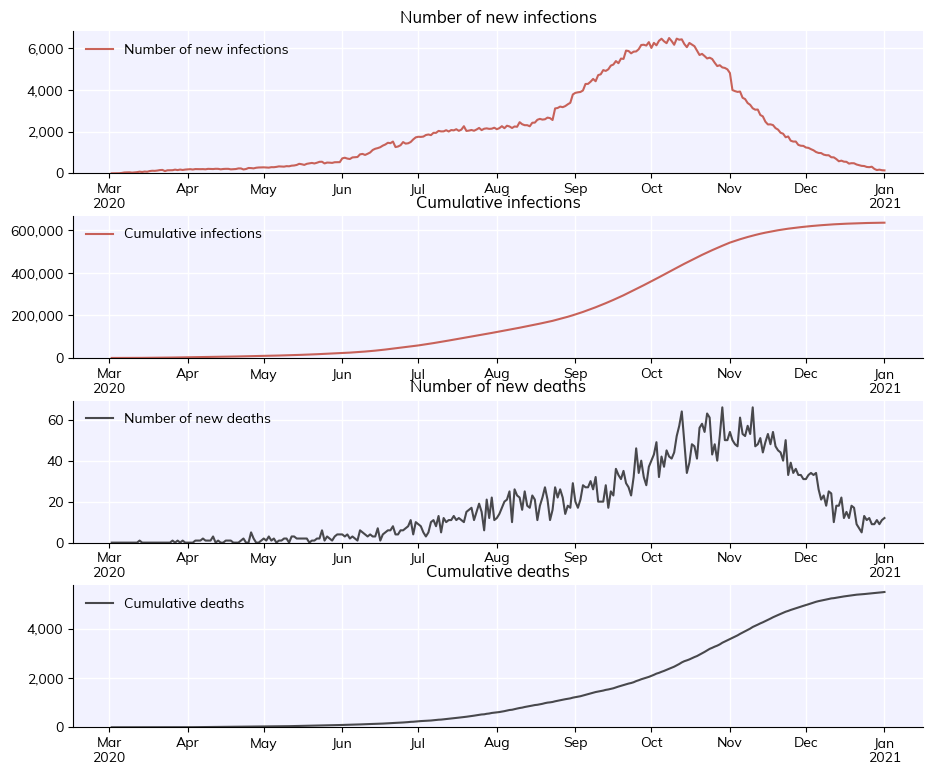

In [11]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions2=cv.Sim(parameters_sweden_bis, interventions=cb_mobility_2)
    my_simulation_sweden_interventions2.run()
    my_simulation_sweden_interventions2.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])

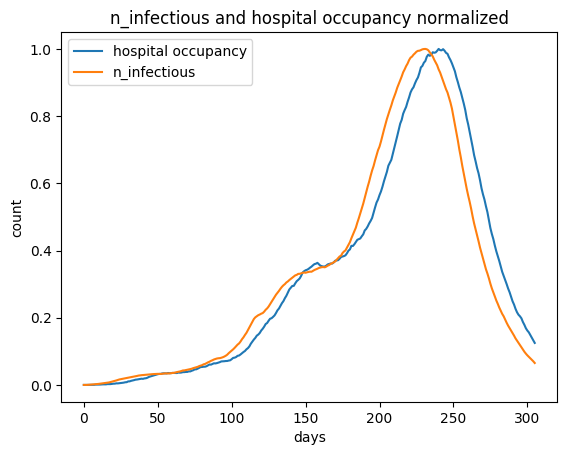

In [32]:
# plt.plot(my_simulation_sweden_interventions2.results['new_deaths'], label='new_deaths')
# plt.plot(my_simulation_sweden_interventions2.results['n_severe'], label='n_severe')
plt.plot(my_simulation_sweden_interventions2.results['n_severe']/np.max(np.array(my_simulation_sweden_interventions2.results['n_severe'])), label='hospital occupancy')

plt.xlabel('days')
plt.ylabel('count')
# plt.show()

plt.plot(my_simulation_sweden_interventions2.results['n_infectious']/np.max(np.array(my_simulation_sweden_interventions2.results['n_infectious'])), label='n_infectious')
# plt.xlabel('days')
# plt.ylabel('new infectious')
plt.title('n_infectious and hospital occupancy normalized')
plt.legend()



In [21]:
n_infectious=np.array(my_simulation_sweden_interventions2.results['n_infectious'])

In [16]:
hospitalized=np.array(my_simulation_sweden_interventions2.results['n_severe'])

In [23]:
pd.DataFrame({'hospitalized' : hospitalized, 'n_infectious' : n_infectious}).to_csv('hopitalized_and_infectious.csv')

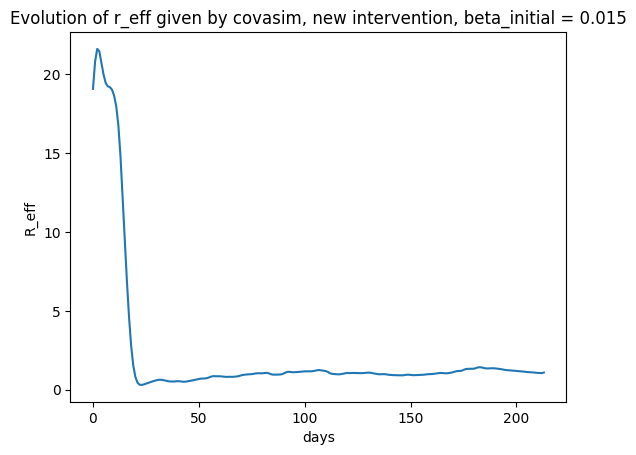

In [37]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions2.compute_r_eff())
plt.title('Evolution of r_eff given by covasim, new intervention, beta_initial = 0.015')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

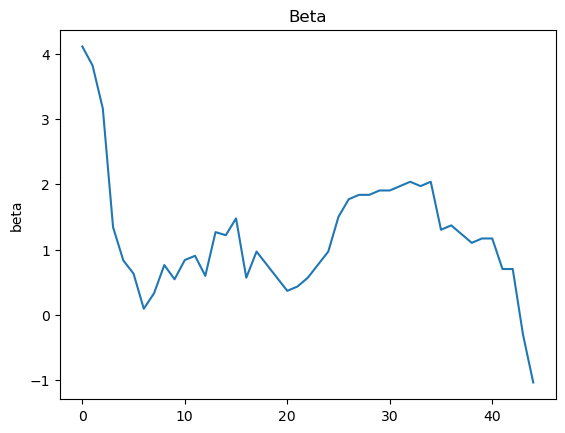

In [8]:
plt.plot(np.array(betas))
plt.title('Beta')
plt.ylabel('beta')
plt.show()


Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (11.67 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (14.75 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (18.08 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (21.43 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (24.91 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (28.21 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (31.61 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (35.26 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (39.68 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (45.22 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (52.64 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (60.77 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (68.62 s)  •••••••••••••••••••— 99%
Simulation summary:
      889,845 cumulative in

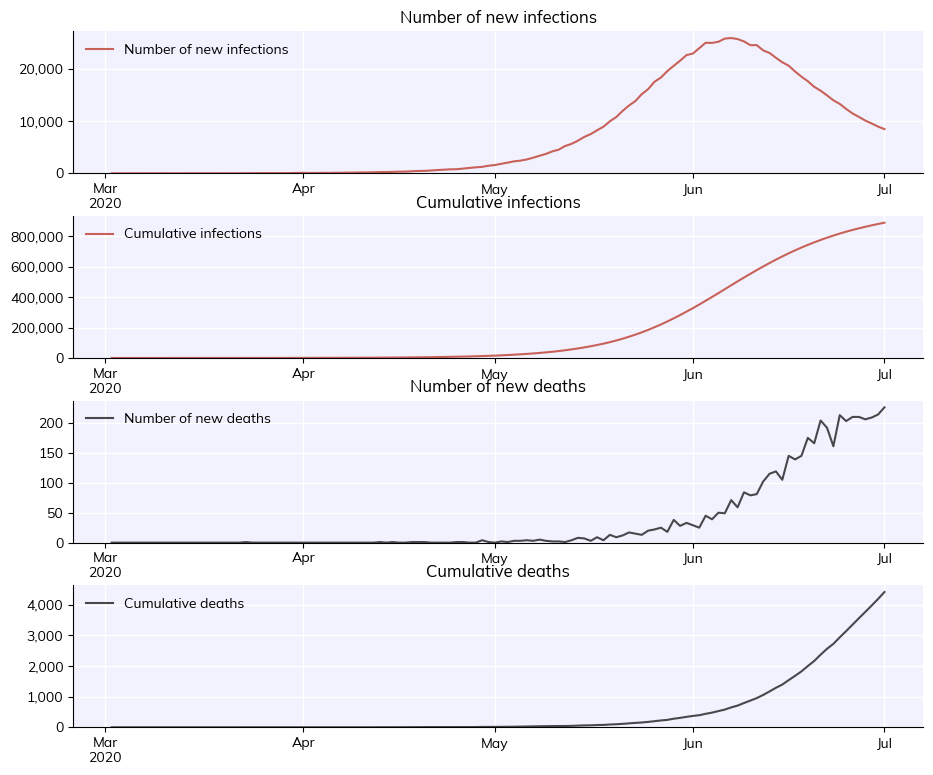

In [32]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions2=cv.Sim(parameters_sweden)
    my_simulation_sweden_interventions2.run()
    my_simulation_sweden_interventions2.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


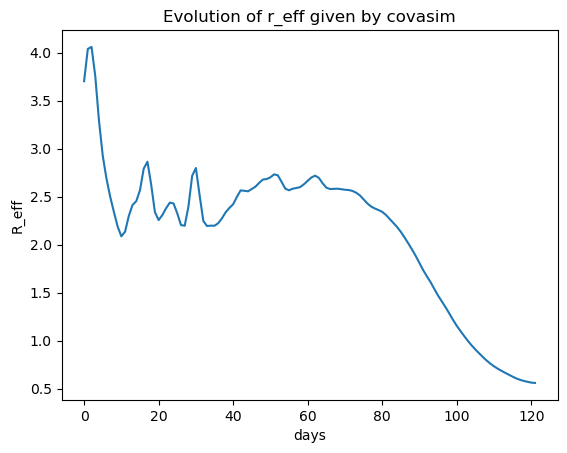

In [34]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions2.compute_r_eff())
plt.title('Evolution of r_eff given by covasim')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

Initializing sim with 1000000 people for 121 days
Loading location-specific data for "Sweden"
  Running 2020-03-02 ( 0/121) (13.46 s)  ———————————————————— 1%
  Running 2020-03-12 (10/121) (17.82 s)  •——————————————————— 9%
  Running 2020-03-22 (20/121) (26.39 s)  •••————————————————— 17%
  Running 2020-04-01 (30/121) (37.15 s)  •••••——————————————— 25%
  Running 2020-04-11 (40/121) (48.56 s)  ••••••—————————————— 34%
  Running 2020-04-21 (50/121) (59.17 s)  ••••••••———————————— 42%
  Running 2020-05-01 (60/121) (70.57 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (70/121) (82.77 s)  •••••••••••————————— 58%
  Running 2020-05-21 (80/121) (93.82 s)  •••••••••••••——————— 66%
  Running 2020-05-31 (90/121) (105.35 s)  ••••••••••••••—————— 75%
  Running 2020-06-10 (100/121) (115.45 s)  ••••••••••••••••———— 83%
  Running 2020-06-20 (110/121) (126.19 s)  ••••••••••••••••••—— 91%
  Running 2020-06-30 (120/121) (137.09 s)  •••••••••••••••••••— 99%
Simulation summary:
    5,702,320 cumulativ

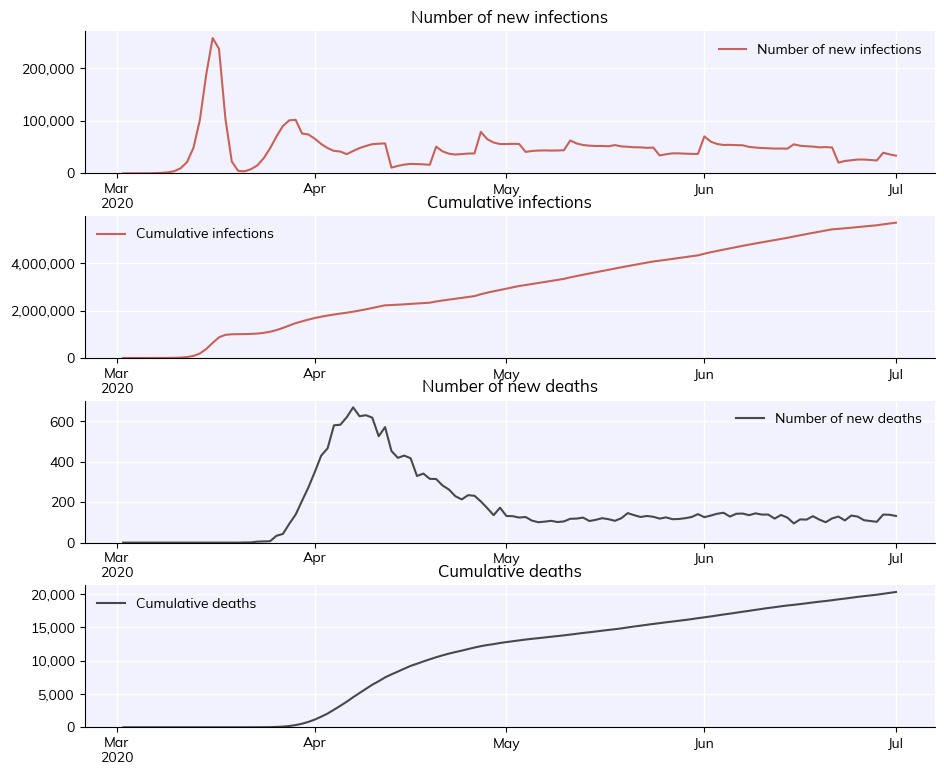

In [27]:
# set run_simul = True to run the simulation and create data : 
run_simul=True
if run_simul: 
    my_simulation_sweden_interventions=cv.Sim(parameters_sweden, interventions=cb_mobility)
    my_simulation_sweden_interventions.run()
    my_simulation_sweden_interventions.plot([ 'new_infections', 'cum_infections', 'new_deaths', 'cum_deaths'])


In [29]:
my_simulation_sweden_interventions.compute_r_eff()

array([1.15794520e+02, 1.26321295e+02, 1.33551753e+02, 1.36248741e+02,
       1.35636921e+02, 1.33533652e+02, 1.30496182e+02, 1.27313053e+02,
       1.24692759e+02, 1.22500651e+02, 1.19864187e+02, 1.14537455e+02,
       1.02860707e+02, 8.22581375e+01, 5.50669259e+01, 2.89614453e+01,
       1.12016985e+01, 2.95922381e+00, 5.16776878e-01, 1.09523779e-01,
       1.09855552e-01, 1.92546085e-01, 3.38036177e-01, 5.55994024e-01,
       8.40701458e-01, 1.15871206e+00, 1.42727052e+00, 1.54032891e+00,
       1.49130560e+00, 1.36653447e+00, 1.20091381e+00, 1.00107489e+00,
       8.17308885e-01, 6.87571628e-01, 6.10647106e-01, 5.88956774e-01,
       6.31264419e-01, 7.19371841e-01, 8.21263327e-01, 9.18729102e-01,
       9.45956021e-01, 7.87252314e-01, 5.06839119e-01, 3.38327409e-01,
       3.33329999e-01, 3.69474392e-01, 3.90669250e-01, 4.66184350e-01,
       7.16415346e-01, 1.06255003e+00, 1.26557178e+00, 1.30814513e+00,
       1.33599418e+00, 1.38327625e+00, 1.50154115e+00, 1.82309919e+00,
      

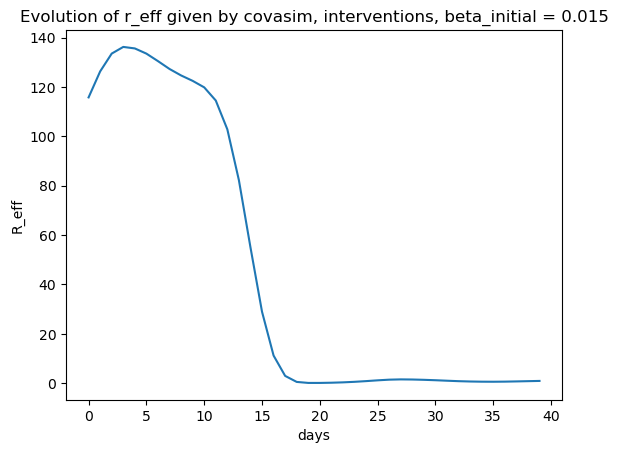

In [29]:
# plt.plot(n_infected[:40])
plt.plot(my_simulation_sweden_interventions.compute_r_eff()[:40])
plt.title('Evolution of r_eff given by covasim, interventions, beta_initial = 0.015')
plt.xlabel('days')
plt.ylabel('R_eff')
plt.show()

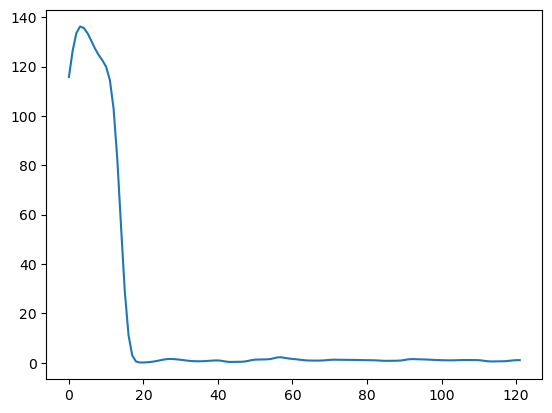

In [11]:
plt.plot(my_simulation_sweden_interventions.compute_r_eff())

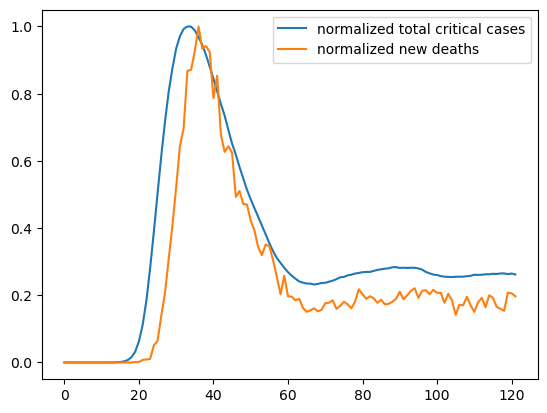

In [12]:
plt.plot(my_simulation_sweden_interventions.results['n_critical']/max(my_simulation_sweden_interventions.results['n_critical']), label='normalized total critical cases')
plt.plot(my_simulation_sweden_interventions.results['new_deaths']/max(my_simulation_sweden_interventions.results['new_deaths']), label='normalized new deaths')
plt.legend()
plt.show()


We have stored in a csv file the synthetized data and extract it as a baseline: 

In [13]:
df = pd.read_csv('deaths_and_infections.csv')
# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)

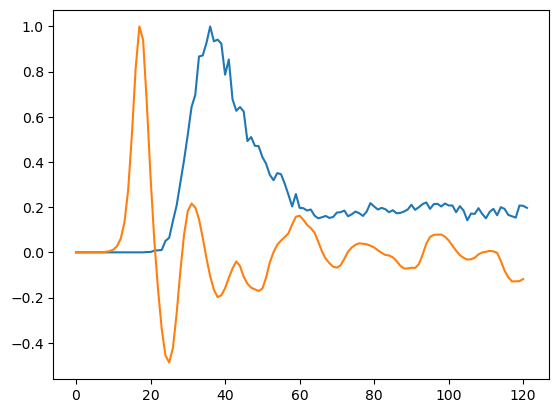

In [14]:
new_deaths=np.array(df['new_deaths'])
n_infected=np.array(df['n_infected'])
new_infected=np.array([n_infected[i+1] - n_infected[i] for i in range(len(n_infected) -1)])
plt.plot(new_deaths/max(new_deaths))
plt.plot(new_infected/max(new_infected))

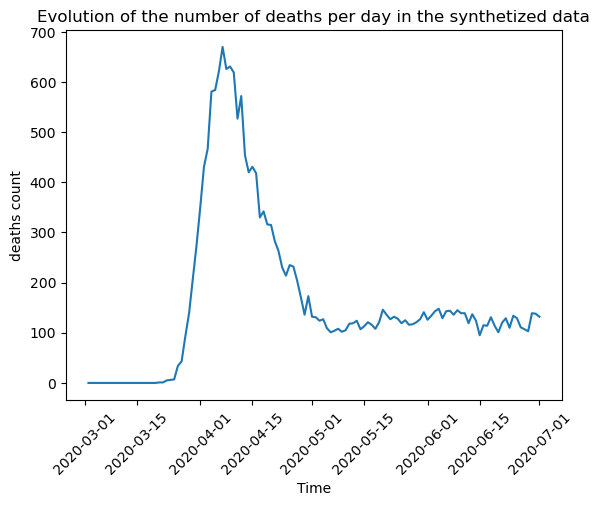

In [15]:
plt.plot(date_range, df['new_deaths'], label='new_deaths')
plt.title('Evolution of the number of deaths per day in the synthetized data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('deaths count')

plt.show()

In [16]:
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

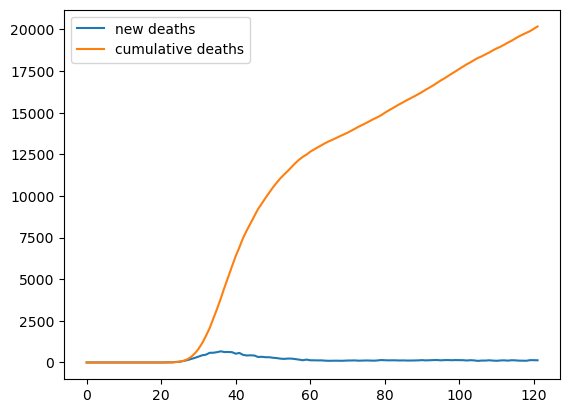

In [17]:
plt.plot(dates_of_pandemic,new_deaths, label='new deaths')
plt.plot(dates_of_pandemic,death_cumul, label='cumulative deaths')
plt.legend()
plt.show()

We try to fit some simple models

In [18]:
def exponential_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [19]:
def polynomla_func(x, a, b, c, d, e , f):
    return a*x**2+b*x+c + e*x**3 

In [20]:
p, _ =curve_fit(exponential_func, dates_of_pandemic, new_deaths)
p
p2, _ =curve_fit(polynomla_func, dates_of_pandemic, new_deaths)


c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


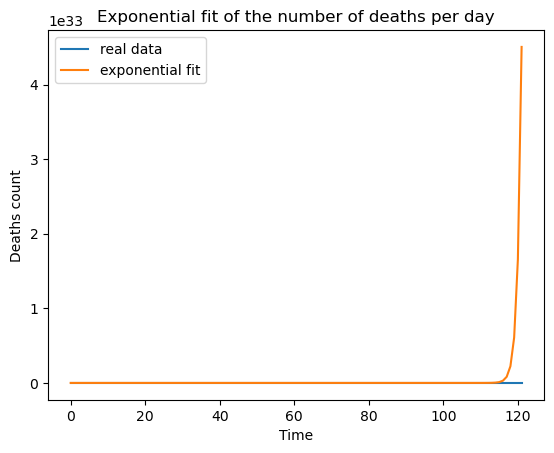

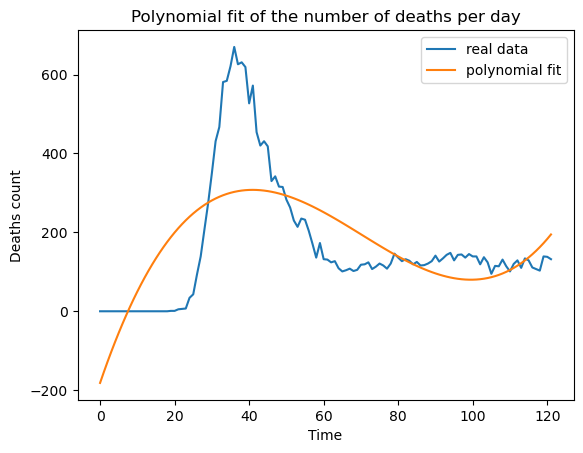

In [21]:
plt.plot(dates_of_pandemic,new_deaths, label='real data')
plt.plot(dates_of_pandemic, exponential_func(dates_of_pandemic, *p), label= 'exponential fit')
plt.title('Exponential fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()

plt.plot(dates_of_pandemic,new_deaths,  label='real data')
plt.plot(dates_of_pandemic, polynomla_func(dates_of_pandemic, *p2), label= 'polynomial fit')
plt.title('Polynomial fit of the number of deaths per day')
plt.xlabel('Time')
plt.ylabel('Deaths count')

plt.legend()
plt.show()


